In [2]:
import scanpy as sc
import anndata
from anndata import AnnData
import pandas as pd
import numpy as np
import random
import scipy as sci
import scipy.sparse as sps

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
%config InlineBackend.figure_format = 'retina'
sc.settings.set_figure_params(dpi=50, dpi_save=300, figsize=(4,4))


In [4]:
import shutil
import pickle
import os

def save(var, name):
    if os.path.exists(name+'.pkl'):
        os.remove(name+'.pkl')
    with open(name+'.pkl', 'wb') as f:
        pickle.dump(var, f)
        
def load(name):
    if not os.path.exists(name+'.pkl'):
        raise ValueError(name)
    with open(name+'.pkl', 'rb') as f:
        return pickle.load(f)
    
def flo2str(n):
    """
    transform a number into a succint string.
    Args:
        n: a number
    Returns:
        return the corresponding string
    """
    n = str(n)
    if '.' in n:
        n = n.rstrip('0') # delete extra zeros of decimal
        if n.endswith('.'):
            n = n.rstrip('.')
    return n

def savepic(pth, name):
    if not os.path.exists(pth):
        os.makedirs(pth)
    pic = pth+'/'+name
    if os.path.exists(pic+'.png'):
        os.remove(pic+'.png')
    plt.savefig(pic, bbox_inches='tight')

In [5]:
from functions import calc

# visium_brain

In [130]:
lamb = 10
similarity = ['SNN15','SNN','SPR']
initial = ['rand', 'nmf', 'nndsvd', 'wegsvd', 'tcdsvd']
multiple = [1, 3, 5]

random.seed(101)
pth = os.path.join(os.getcwd(), 'visium_brain_sagittal')
dpth = os.path.join(pth, 'data')
wpth = os.path.join(pth, 'wedge')
if not os.path.exists(wpth):
    os.makedirs(wpth)

### data preparation

In [107]:
# %% QC, loosely following MEFISTO tutorials
# https://nbviewer.jupyter.org/github/bioFAM/MEFISTO_tutorials/blob/master/MEFISTO_ST.ipynb#QC-and-preprocessing
# paper_data/visium_brain_sagittal/data/original
ad = sc.read_visium(os.path.join(dpth,'original'),
                    count_file='V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5')
ad.var_names_make_unique()
ad.var['mt'] = ad.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20]
sc.pp.filter_genes(ad, min_cells=1)
sc.pp.filter_cells(ad, min_counts=100)
ad.layers = {'counts':ad.X.copy()} #store raw counts before normalization changes ad.X
sc.pp.normalize_total(ad, inplace=True, layers=None, key_added='sizefactor')
sc.pp.log1p(ad)
#Y = misc.reverse_normalization(np.expm1(ad.X),ad.obs["sizefactor"])
#np.max(np.abs(Y-np.layers["counts"]))

In [ ]:
# %% normalization, feature selection and train/test split
ad.var['deviance_poisson'] = calc.deviancePoisson(ad.layers['counts'])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
ad.write_h5ad(os.path.join(dpth,'visium_brain_sagittal.h5ad'),compression='gzip')
#ad = sc.read_h5ad(os.path.join(pth,"paper_data/visium_brain_sagittal.h5ad"))
ad2 = ad[:,:2000]
ad2.write_h5ad(os.path.join(dpth,'visium_brain_sagittal_J2000.h5ad'),compression='gzip')

In [ ]:
sp_radius = ad.uns['spatial']['V1_Mouse_Brain_Sagittal_Anterior']['scalefactors']['spot_diameter_fullres']

x = ad2.layers['counts'].todense()
x = np.array(x)
save(x, wpth+'/x')

xnorm = calc.median_normalize(x)
xnorm = np.array(xnorm)
save(xnorm, wpth+'/xnorm')

spatial = ad2.obsm['spatial']#坐标
save(spatial, wpth+'/spa')

In [32]:
# each subfolder contains 'spa'
for spr in [75,85,95]:
    spr_pth = os.path.join(wpth, str(spr))
    _= shutil.copy(wpth+'/spa.pkl', spr_pth+'/spa.pkl')

### clusters

In [131]:
# %% Data Loading from scanpy
J = 2000
ad = sc.read_h5ad(os.path.join(dpth, "visium_brain_sagittal_J{}.h5ad".format(J)))#[:,:J]

In [7]:
pic_pth = os.path.join(wpth, 'plots', 'prime')
if not os.path.exists(pic_pth):
    os.makedirs(pic_pth)

In [9]:
cluster = pd.read_csv(os.path.join(dpth, 'original/analysis/clustering/graphclust/clusters.csv'),index_col=0)
cluster = cluster.loc[ad.obs_names]
#cluster.shape
#cluster.head(1)
tsne = pd.read_csv(os.path.join(dpth, 'original/analysis/tsne/2_components/projection.csv'),index_col=0)
tsne = tsne.loc[ad.obs_names]
tsne = pd.merge(tsne,cluster,how='outer',left_index=True, right_index=True)
#tsne.shape
#tsne.isnull().any().sum()
#tsne.head(1)
umap = pd.read_csv(os.path.join(dpth, 'original/analysis/umap/2_components/projection.csv'),index_col=0)
umap = umap.loc[ad.obs_names]
umap = pd.merge(umap,cluster,how='outer',left_index=True, right_index=True)
#umap.shape
#umap.isnull().any().sum()
#umap.head(1)

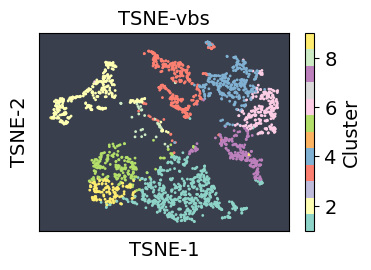

In [49]:
fig, ax = plt.subplots()
ax.set_facecolor('#393F4C')
_= tsne.plot.scatter(x='TSNE-1', y='TSNE-2', c='Cluster', ax=ax, figsize=(4,2.6), colormap='Set3', s=1)
_= plt.title('TSNE-vbs')
_= plt.xticks([])
_= plt.yticks([])
savepic(pic_pth, 'tsne-vbs')
plt.show()

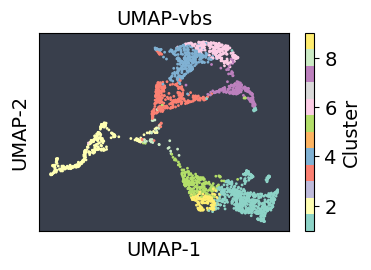

In [51]:
fig, ax = plt.subplots()
ax.set_facecolor('#393F4C')
t = umap.plot.scatter(x='UMAP-1', y='UMAP-2', c='Cluster', ax=ax, figsize=(4,2.6), colormap='Set3', s=1)
t = plt.title('UMAP-vbs')
_= plt.xticks([])
_= plt.yticks([])
savepic(pic_pth, 'umap-vbs')
plt.show()

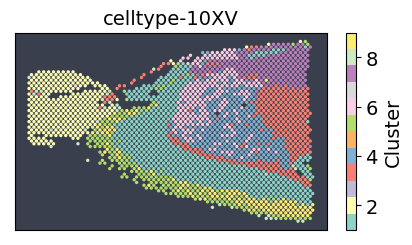

In [11]:
spatial = pd.DataFrame(ad.obsm['spatial'], index=ad.obs_names, columns=['X','Y'])
spatial = pd.merge(spatial,cluster,how='outer',left_index=True, right_index=True)
fig, ax = plt.subplots()
ax.set_facecolor('#393F4C')
t = spatial.plot.scatter(x='X', y='Y', c='Cluster', ax=ax, figsize=(5,2.6), colormap='Set3', s=2)
t = plt.title('celltype-10XV')
_= plt.xticks([])
_= plt.yticks([])
_= plt.xlabel('')
_= plt.ylabel('')
savepic(pic_pth, 'celltype-10XV')
fig.show()

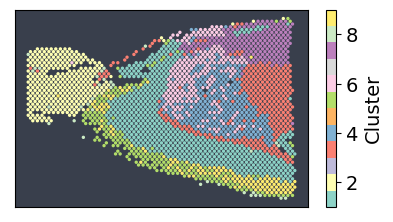

In [135]:
spatial = pd.DataFrame(ad.obsm['spatial'], index=ad.obs_names, columns=['X','Y'])
spatial = pd.merge(spatial,cluster,how='outer',left_index=True, right_index=True)
fig, ax = plt.subplots()
ax.set_facecolor('#393F4C')
t = spatial.plot.scatter(x='X', y='Y', c='Cluster', ax=ax, figsize=(4.7,2.6), colormap='Set3', s=2)
_= plt.xticks([])
_= plt.yticks([])
_= plt.xlabel('')
_= plt.ylabel('')
savepic(sd_pth, 'celltype10XV')
fig.show()

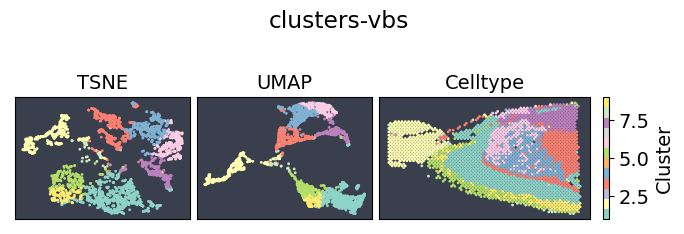

In [53]:
#画在同一张图中
#from matplotlib import gridspec

fig = plt.figure(figsize=(7,2.4))
spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[2, 2, 3])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])
ax1.set_facecolor('#393F4C')
ax2.set_facecolor('#393F4C')
ax3.set_facecolor('#393F4C')
_= fig.suptitle('clusters-vbs')#标题
_= tsne.plot.scatter(x='TSNE-1', y='TSNE-2', c='Cluster',ax=ax1, colormap='Set3', s=1, colorbar=False, title = 'TSNE')
_= umap.plot.scatter(x='UMAP-1', y='UMAP-2', c='Cluster',ax=ax2, colormap='Set3', s=1, colorbar=False, title = 'UMAP')
_= spatial.plot.scatter(x='X', y='Y', c='Cluster',ax=ax3, colormap='Set3', s=1, title = 'Celltype')
_= ax1.set_xticks([])
_= ax2.set_xticks([])
_= ax3.set_xticks([])
_= ax1.set_yticks([])
_= ax2.set_yticks([])
_= ax3.set_yticks([])
_= ax1.set_xlabel('')
_= ax2.set_xlabel('')
_= ax3.set_xlabel('')
_= ax1.set_ylabel('')
_= ax2.set_ylabel('')
_= ax3.set_ylabel('')
fig.tight_layout(w_pad=0.1, h_pad=0.1)
savepic(pic_pth, 'combine-vbs')
plt.show()

### sparisify

In [ ]:
X = load(wpth+'/x') #原始表达
X = sps.csr_matrix(X) #稀疏表示
num = X.shape[0] * X.shape[1]
nonnull = len(X.data) #非0个数
spar = 1 - nonnull / num
print('稀疏度为', spar)
for spr in [75,85,95]:
    spr_pth = os.path.join(wpth,str(spr)) #稀疏度
    if not os.path.exists(spr_pth):
        os.makedirs(spr_pth)
    else:
        shutil.rmtree(spr_pth)
        os.makedirs(spr_pth)
    sparse = X.copy()
    random.seed(111)
    setnull = random.sample(range(nonnull), round(num*(0.01*spr-spar))) #赋0值下标
    sparse.data[setnull] = 0.
    sparse = np.array(sparse.todense())
    save(sparse, spr_pth+'/x')
    spr_norm = median_normalize(sparse)
    save(spr_norm, spr_pth+'/xnorm')

### sprod

In [ ]:
source = os.path.join(dpth, 'original/V1_Mouse_Brain_Sagittal_Anterior_image.tif') #tif

meta = pd.DataFrame(spatial, index=range(spatial.shape[0]), columns=['X','Y'])
meta['Spot_radius'] = sp_radius
for spr in [75,85,95]:
    spr_pth = os.path.join(wpth, str(spr)) #稀疏度
    xnorm = load(spr_pth+'/xnorm')
    cts = pd.DataFrame(xnorm, index=range(xnorm.shape[0]), columns=range(xnorm.shape[1]))
    inpth = os.path.join(spr_pth,'input')
    outpth = os.path.join(spr_pth,'output')
    if not os.path.exists(inpth):
        os.makedirs(inpth)
    else:
        shutil.rmtree(inpth)
        os.makedirs(inpth)
    if not os.path.exists(outpth):
        os.makedirs(outpth)
    else:
        shutil.rmtree(outpth)
        os.makedirs(outpth)

    try:
        t = shutil.copy(source, inpth)
    except IOError as e:
        print("Unable to copy file. %s" % e)
    except:
        print("Unexpected error:", sys.exc_info())

    os.rename(inpth+'/V1_Mouse_Brain_Sagittal_Anterior_image.tif', inpth+'/image.tif')
    meta.to_csv(inpth+'/Spot_metadata.csv')
    cts.to_csv(inpth+'/Counts.csv', sep='\t')

In [ ]:
# python sprod.py inpth outpth/res -k 8 -l 15 -r 0.1 -y batch -pb 2
# python sprod.py inpth outpth -k 8 -l 15 -r 0.1 -y single -ws -ag

In [21]:
for spr in [75,85,95]:
    spr_pth = os.path.join(wpth, str(spr))
    sprod_pth = os.path.join(spr_pth, 'output', 'res')
    xsprod = pd.read_csv(sprod_pth+'/denoised_stitched.txt', sep='\t', index_col=0)
    xsprod = xsprod.to_numpy()
    save(xsprod, spr_pth+'/xsprod')

### wedge

In [22]:
#csv
wdg_pth = '/home/qukun/muziyu/wdg'
for spr in [75,85,95]:
    spr_pth = os.path.join(wpth, str(spr))
    xnorm = load(spr_pth+'/xnorm')
    index = list(map(lambda x:'gene'+str(x),range(xnorm.shape[1])))
    col = list(map(lambda x:'cell'+str(x),range(xnorm.shape[0])))
    cts = pd.DataFrame(xnorm.T, index=index, columns=col)
    cts.to_csv(wdg_pth+'/'+str(spr)+'vbs.csv', sep=',',index=False)

In [28]:
#result
wdg_pth = '/home/qukun/muziyu/sprod_data/sim/wedge/'
for spr in [75,85,95]:
    d_pth = os.path.join(wdg_pth,'vbs',str(spr))
    spr_pth = os.path.join(wpth,str(spr))
    W = pd.read_csv(d_pth+'W.csv', header=None)
    W = W.to_numpy()
    H = pd.read_csv(d_pth+'H.csv', header=None)
    H = H.to_numpy()
    rk_wdg = W.shape[1]
    save(rk_wdg, spr_pth+'/rk_wdg')
    xwedge = np.dot(W, H)
    save(xwedge.T, spr_pth+'/xwedge')

### similarity matrix

In [ ]:
#SNN
for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr)) #稀疏度
    xnorm = load(spr_pth+'/xnorm')
    sim = calc.SNN(xnorm)
    save(sim, spr_pth+'/sSNN')
    sim15 = calc.SNN(xnorm, k=15)
    save(sim4, spr_pth+'/sSNN15')

In [ ]:
#SPR
for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr)) 
    sim_sr = pd.read_csv(spr_pth+'/output/sprod_Detected_graph.txt', sep='\t')
    sim_sr = sim_sr.to_numpy()
    save(sim_sr, spr_pth+'/sSPR')

### dimension check

In [10]:
xori = load(wpth+'/xnorm')
dim_w, dim_a = calc.rank_w_a(xori)
save(dim_w, wpth+'/dim_wedge')
save(dim_a, wpth+'/dim_alra')
print('  wedge','alra')
print('ori',':', dim_w, dim_a)

ori : 11 11


In [24]:
print('  wedge','alra')
for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr))
    xnorm = load(spr_pth+'/xnorm')
    dim_w, dim_a = calc.rank_w_a(xnorm)
    save(dim_w, spr_pth+'/dim_wedge')
    save(dim_a, spr_pth+'/dim_alra')
    print(spr,':', dim_w, dim_a)

75 : 3 2
85 : 3 6
95 : 3 1


In [ ]:
for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr)) 
    calc.svdSIGdif_plot(spr_pth, dname='-'+str(spr)+'%-vbs')

### statistics

In [20]:
lamb = 10

xnorm = load(wpth+'/xnorm')
ori_cell_cor = np.corrcoef(xnorm)
ori_gene_cor = np.corrcoef(xnorm.T)

for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr))
    dim_w = load(spr_pth+'/dim_wedge')
    for init in initial:
        if spr == 95:
            weight = [0.1, 0.2]
        else:
            weight = [0.5, 0.7]
        for w in weight:
            file = 'w'+flo2str(w)+'-l'+flo2str(lamb)
            for m in multiple:
                dim = min(dim_w * m, 30)
                for sim in similarity:
                    res_pth = os.path.join(spr_pth, 'result', init, file+'-d'+flo2str(dim), sim)
                    stat_pth = os.path.join(res_pth, 'statistics')
                    if not os.path.exists(stat_pth):
                        os.makedirs(stat_pth)
                    X = load(res_pth+'/x_'+sim)
                    pcc_cell, pcc_p_cell = calc.PCC(xnorm, X)
                    pcc_gene, pcc_p_gene = calc.PCC(xnorm.T, X.T)
                    save(pcc_cell, stat_pth+'/pcc_cell_'+sim)
                    save(pcc_p_cell, stat_pth+'/pcc_p_cell_'+sim)
                    save(pcc_gene, stat_pth+'/pcc_gene_'+sim)
                    save(pcc_p_gene, stat_pth+'/pcc_p_gene_'+sim)
                    #rmse = calc.RMSE(xnorm, X)
                    #save(rmse, stat_pth+'/rmse_'+sim)
                    wdg_cell_cor = np.corrcoef(X)
                    wdg_gene_cor = np.corrcoef(X.T)
                    CMD_cell = calc.CMD(ori_cell_cor, wdg_cell_cor)
                    save(CMD_cell, stat_pth+'/cmd_cell_'+sim)
                    CMD_gene = calc.CMD(ori_gene_cor, wdg_gene_cor)
                    save(CMD_gene, stat_pth+'/cmd_gene_'+sim)

In [42]:
# time
time_dict = {}
for sim in similarity:
    time_dict_sim = {}
    for init in initial:
        runTime = []
        for spr in [75,85,95]:#稀疏度
            spr_pth = os.path.join(wpth,str(spr))
            if spr==95:
                wlist = [0.1, 0.2]
            else:
                wlist = [0.5, 0.7]
            dim_w = load(spr_pth+'/dim_wedge')
            dlist = list(map(lambda x:min(dim_w * x, 30), multiple))
            for w in wlist:
                for d in dlist:
                    file = 'w'+flo2str(w)+'-l'+flo2str(lamb)+'-d'+flo2str(d)
                    res_pth = os.path.join(spr_pth, 'result', init, file, sim)
                    rt = load(res_pth+'/time_'+sim)
                    runTime.append(rt)
        time_dict_sim[init] = np.mean(runTime) 
    time_dict[sim] = time_dict_sim
save(time_dict, wpth+'/time')

In [27]:
#cluster
J = 2000
ad = sc.read_h5ad(os.path.join(dpth, "visium_brain_sagittal_J{}.h5ad".format(J)))#[:,:J]
cluster = pd.read_csv(os.path.join(dpth, 'original/analysis/clustering/graphclust/clusters.csv'), index_col=0)
cluster = cluster.loc[ad.obs_names]
obs = pd.merge(ad.obs,cluster,how='outer',left_index=True, right_index=True)
var = ad.var
del ad

In [7]:
oriClus = obs['Cluster'].values.tolist()
for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr))
    save(oriClus, spr_pth+'/oriClus')
    dim_w = load(spr_pth+'/dim_wedge')
    for init in initial:
        if spr == 95:
            weight = [0.1, 0.2]
        else:
            weight = [0.5, 0.7]
        for w in weight:
            file = 'w'+flo2str(w)+'-l'+flo2str(lamb)
            for m in multiple:
                dim = min(dim_w * m, 30)
                for sim in similarity:
                    res_pth = os.path.join(spr_pth, 'result', init, file+'-d'+flo2str(dim), sim)
                    uamp_pth = os.path.join(res_pth, 'umap')
                    stat_pth = os.path.join(res_pth, 'statistics')
                    if not os.path.exists(uamp_pth):
                        os.makedirs(uamp_pth)
                    if not os.path.exists(stat_pth):
                        os.makedirs(stat_pth)
                        
                    X = load(res_pth+'/x_'+sim)
                    calc.umap(x=X, obs=obs, var=var, savepth=uamp_pth)
                    umapClus = load(uamp_pth+'/umapClus')
                    xpca = load(uamp_pth+'/xpca')
                    
                    ari = calc.ARI(oriClus, umapClus)
                    save(ari, stat_pth+'/ari_'+sim)
                    jcrd = calc.Jaccard(oriClus, umapClus)
                    save(jcrd, stat_pth+'/jcrd_'+sim)
                    slt = calc.Silhouette(xpca, umapClus)
                    save(slt, stat_pth+'/slt_'+sim)

2023-05-19 23:01:01.231559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 23:01:06.215514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/gridview//pbs/dispatcher/lib:/opt/gridview//pbs/dispatcher/lib::/usr/local/lib64:/usr/local/lib:/usr/local/lib64:/usr/local/lib
2023-05-19 23:01:06.216234: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-19 23:01:28.337061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_lo

In [28]:
#wedge&sprod&sparse
xnorm = load(wpth+'/xnorm')
ori_cell_cor = np.corrcoef(xnorm)
ori_gene_cor = np.corrcoef(xnorm.T)

for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr))
    oriClus = load(spr_pth+'/oriClus')
    for method in ['sprod','wedge','norm']:
        umap_pth = os.path.join(spr_pth, 'statistics', method, 'umap')
        stat_pth = os.path.join(spr_pth, 'statistics', method)
        if not os.path.exists(umap_pth):
            os.makedirs(umap_pth)
        if not os.path.exists(stat_pth):
            os.makedirs(stat_pth)
            
        X = load(spr_pth+'/x'+method)
        calc.umap(x=X, obs=obs, var=var, savepth=umap_pth)
        oriClus = obs['Cluster'].values.tolist()
        umapClus = load(umap_pth+'/umapClus')
        xpca = load(umap_pth+'/xpca')
        
        ari = calc.ARI(oriClus, umapClus)
        save(ari, stat_pth+'/ari_'+method)
        jcrd = calc.Jaccard(oriClus, umapClus)
        save(jcrd, stat_pth+'/jcrd_'+method)
        slt = calc.Silhouette(xpca, umapClus)
        save(slt, stat_pth+'/slt_'+method)
                    
        pcc_cell, pcc_p_cell = calc.PCC(xnorm, X)
        pcc_gene, pcc_p_gene = calc.PCC(xnorm.T, X.T)
        save(pcc_cell, stat_pth+'/pcc_cell_'+method)
        save(pcc_p_cell, stat_pth+'/pcc_p_cell_'+method)
        save(pcc_gene, stat_pth+'/pcc_gene_'+method)
        save(pcc_p_gene, stat_pth+'/pcc_p_gene_'+method)
        wdg_cell_cor = np.corrcoef(X)
        wdg_gene_cor = np.corrcoef(X.T)
        CMD_cell = calc.CMD(ori_cell_cor, wdg_cell_cor)
        save(CMD_cell, stat_pth+'/cmd_cell_'+method)
        CMD_gene = calc.CMD(ori_gene_cor, wdg_gene_cor)
        save(CMD_gene, stat_pth+'/cmd_gene_'+method)

In [32]:
xnorm = load(wpth+'/xnorm')
ori_cell_cor = np.corrcoef(xnorm)
ori_gene_cor = np.corrcoef(xnorm.T)

lambdas = [5,18,25,30]
dim = 9
init = 'wdgsvd'
sim = 'SPR'

for spr in [75, 85, 95]:
    spr_pth = os.path.join(wpth, str(spr))
    if spr == 95:
        w = 0.2
    else:
        w = 0.5
    oriClus = load(spr_pth+'/oriClus')
    file = 'w'+flo2str(w)+'-d'+flo2str(dim)
    for lamb in lambdas:
        res_pth = os.path.join(spr_pth, 'result', file, 'l'+flo2str(lamb))
        umap_pth = os.path.join(res_pth, 'umap')
        stat_pth = os.path.join(res_pth, 'statistics')
        if not os.path.exists(umap_pth):
            os.makedirs(umap_pth)
        if not os.path.exists(stat_pth):
            os.makedirs(stat_pth)
        
        X = load(res_pth+'/x_'+sim)
        calc.umap(x=X, obs=obs, var=var, savepth=umap_pth)
        umapClus = load(umap_pth+'/umapClus')
        xpca = load(umap_pth+'/xpca')
    
        ari = calc.ARI(oriClus, umapClus)
        save(ari, stat_pth+'/ari_'+sim)
        jcrd = calc.Jaccard(oriClus, umapClus)
        save(jcrd, stat_pth+'/jcrd_'+sim)
        slt = calc.Silhouette(xpca, umapClus)
        save(slt, stat_pth+'/slt_'+sim)
    
        pcc_cell, pcc_p_cell = calc.PCC(xnorm, X)
        pcc_gene, pcc_p_gene = calc.PCC(xnorm.T, X.T)
        save(pcc_cell, stat_pth+'/pcc_cell_'+sim)
        save(pcc_p_cell, stat_pth+'/pcc_p_cell_'+sim)
        save(pcc_gene, stat_pth+'/pcc_gene_'+sim)
        save(pcc_p_gene, stat_pth+'/pcc_p_gene_'+sim)
        wdg_cell_cor = np.corrcoef(X)
        wdg_gene_cor = np.corrcoef(X.T)
        CMD_cell = calc.CMD(ori_cell_cor, wdg_cell_cor)
        save(CMD_cell, stat_pth+'/cmd_cell_'+sim)
        CMD_gene = calc.CMD(ori_gene_cor, wdg_gene_cor)
        save(CMD_gene, stat_pth+'/cmd_gene_'+sim)

# slide-seq

In [6]:
lamb = 10
similarity = ['SNN15','SNN','SPR']
multiple = [3, 5, 7]
weight = [0.3, 0.5]
initial = ['rand', 'nndsvd', 'wdgsvd']

random.seed(101)
pth = os.path.join(os.getcwd(), 'slideseq')
dpth = os.path.join(pth, 'data')
wpth = os.path.join(pth, 'wedge')
if not os.path.exists(wpth):
    os.makedirs(wpth)

### data preparation

In [12]:
ad_processed = sc.read_h5ad(os.path.join(dpth, "GSM5173954_OB2-Slide10_slide-seqv2_processed.h5ad"))
ad_processed

AnnData object with n_obs × n_vars = 37956 × 21660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters'
    var: 'features', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [22]:
from scipy.io import mmread
oricts = mmread(os.path.join(dpth,'GSM5173954_OB2_10_expression_matrix.mtx'))
oricts = oricts.T
if oricts.shape == ad_processed.shape:
    ad = sc.AnnData(sps.csr_matrix(oricts))
    ad.obs = ad_processed.obs[['clusters']]
    ad.var = ad_processed.var[['highly_variable']]
    ad.obsm['spatial'] = ad_processed.obsm['spatial']
else:
    print('shape does not match!')

In [15]:
ad = sc.AnnData(sps.csr_matrix(oricts))
ad.obs = ad_processed.obs[['clusters']]
ad.var = ad_processed.var[['highly_variable']]
ad.obsm['spatial'] = ad_processed.obsm['spatial']

In [23]:
ad.var_names_make_unique()
ad.var['mt'] = ad.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20]
sc.pp.filter_cells(ad, min_counts=20)
sc.pp.filter_genes(ad, min_cells=20)

<AxesSubplot:title={'center':'Cluster'}, xlabel='X', ylabel='Y'>

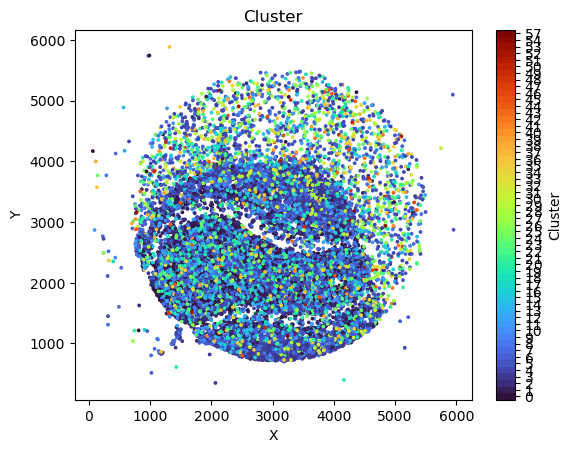

In [24]:
spatial = pd.DataFrame(ad.obsm['spatial'], columns=['X','Y'])
spatial['Cluster'] = ad.obs['clusters'].values
spatial.plot.scatter(x='X', y='Y', c='Cluster', colormap='turbo', s=3, title = 'Cluster')

In [25]:
ad.obs[['X','Y']] = ad.obsm['spatial']
ad = ad[(ad.obs['X']-3000)**2+(ad.obs['Y']-3000)**2<2500**2]
ad.shape

(21716, 14037)

<AxesSubplot:title={'center':'Cluster'}, xlabel='X', ylabel='Y'>

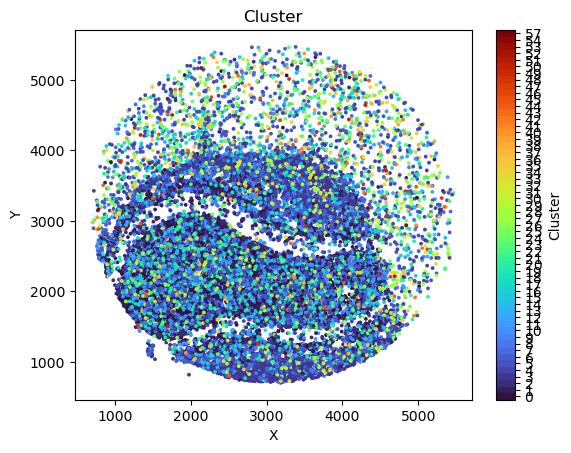

In [26]:
spatial = pd.DataFrame(ad.obsm['spatial'], columns=['X','Y'])
spatial['Cluster'] = ad.obs['clusters'].values
spatial.plot.scatter(x='X', y='Y', c='Cluster', colormap='turbo', s=3, title = 'Cluster')

In [28]:
clus = ad.obs['clusters'].value_counts()
clus = clus[clus > 210]
clus

0     5565
1     2841
3     2311
2     1914
6     1079
7      775
9      701
5      659
4      646
8      623
10     471
14     370
11     362
13     347
12     328
15     296
Name: clusters, dtype: int64

In [29]:
obs = ad.obs
obs = obs[obs.apply(lambda x: x['clusters'] in clus.index, axis=1)]
ad = ad[obs.index]
ad.shape

(19288, 14037)

In [30]:
#取部分数据
from scipy.stats import bernoulli
obs = ad.obs
ind_list = []
stay_list = []
for i in clus.index:
    df_sub = obs[obs['clusters']==i]
    if clus.loc[i] > 5000:
        ratio = 8
    elif clus.loc[i] > 2000:
        ratio = 7
    elif clus.loc[i] > 1000:
        ratio = 6.5
    elif clus.loc[i] > 500:
        ratio = 5
    else:
        ratio = 4.5
    stay = bernoulli.rvs(p=1/ratio, size=df_sub.shape[0], random_state=101)
    ind_list = ind_list + list(df_sub.index)
    stay_list = stay_list + list(stay)

stay_list = np.array(stay_list).reshape(len(stay_list),1)
df = pd.DataFrame(stay_list, columns=['stay'], index=ind_list)
df = df[df['stay'] == 1]
ad = ad[df.index]
ad.shape

(3082, 14037)

In [31]:
sc.pp.filter_cells(ad, min_counts=2)
sc.pp.filter_genes(ad, min_cells=2)
ad.shape

(3082, 13874)

In [32]:
ad.layers = {"counts":ad.X.copy()} #store raw counts before normalization changes ad.X
sc.pp.normalize_total(ad, inplace=True, layers=None, key_added="sizefactor")
sc.pp.log1p(ad)

In [33]:
# %% normalization, feature selection and train/test split
ad.var['deviance_poisson'] = calc.deviancePoisson(ad.layers['counts'])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
ad.write_h5ad(os.path.join(dpth,'slideseq.h5ad'),compression='gzip')
#ad = sc.read_h5ad(os.path.join(pth,"paper_data/visium_brain_sagittal.h5ad"))
ad2 = ad[:,:2000]
ad2.write_h5ad(os.path.join(dpth,'slideseq_J2000.h5ad'),compression='gzip')

In [34]:
print('slide-seq sparsity:',1-len(ad2.X.data)/(ad2.shape[0]*ad2.shape[1]))

slide-seq sparsity: 0.88060009733939


In [35]:
x = ad2.layers['counts'].todense()
x = np.array(x)
save(x, wpth+'/x')

xnorm = calc.median_normalize(x)
xnorm = np.array(xnorm)
save(xnorm, wpth+'/xnorm')

spatial = ad2.obsm['spatial']#坐标
save(spatial, wpth+'/spa')

### clusters

In [111]:
J = 2000
ad = sc.read_h5ad(os.path.join(dpth, "slideseq_J{}.h5ad".format(J)))#[:,:J]

In [119]:
X=ad.X.todense()
X.shape
np.sum(X==0)/(X.shape[0]*X.shape[1])

(3082, 2000)

0.88060009733939

In [14]:
pic_pth = os.path.join(wpth, 'plots')
if not os.path.exists(pic_pth):
    os.makedirs(pic_pth)

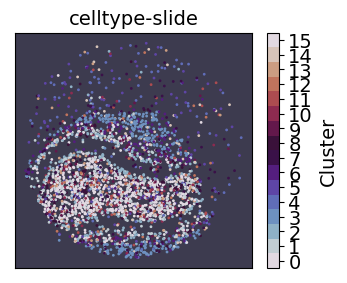

In [18]:
spatial = pd.DataFrame(ad.obsm['spatial'], columns=['X','Y'])
spatial['Cluster'] = ad.obs['clusters'].values
fig, ax = plt.subplots()
ax.set_facecolor('#3D3B4F')
_= spatial.plot.scatter(x='X', y='Y', c='Cluster', ax=ax, figsize=(3.8,3.1), colormap='twilight', s=1)
_= plt.title('celltype-slide')
_= plt.xticks([])
_= plt.yticks([])
_= plt.xlabel('')
_= plt.ylabel('')
savepic(pic_pth, 'celltype-slide')
plt.show()

In [116]:
spatial['Cluster'].value_counts()

0     701
1     400
3     328
2     296
6     177
7     154
9     142
5     137
4     134
8     127
10    108
14     84
11     79
13     77
12     72
15     66
Name: Cluster, dtype: int64

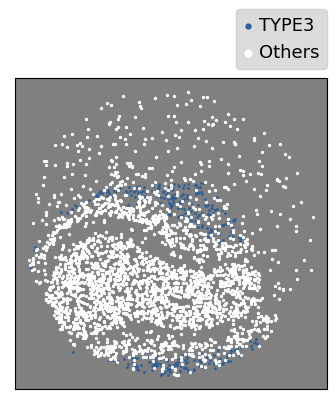

In [127]:
spatial = pd.DataFrame(ad.obsm['spatial'], columns=['X','Y'])
spatial['Cluster'] = ad.obs['clusters'].values.tolist()

fig, ax = plt.subplots(figsize=(4,4.1))
_= ax.set_facecolor('gray')
t1 = spatial.loc[spatial['Cluster']=='3',:]
t2 = spatial.loc[spatial['Cluster']!='3',:]
type1 = ax.scatter(t1['X'].values, t1['Y'].values, s=1, c='#2b5f99')
type2 = ax.scatter(t2['X'].values, t2['Y'].values, s=1, c='#ffffff')
_= plt.title('')
_= plt.xticks([])
_= plt.yticks([])
_= plt.xlabel('')
_= plt.ylabel('')
_=ax.legend((type1, type2), ("TYPE3", "Others"), bbox_to_anchor=(0.68, 1.),facecolor='lightgray',markerscale=3.5)
pic_pth = os.path.join(sd_pth, 'plots', 'simCompare')
savepic(pic_pth,'slide')

### sprod

In [36]:
meta = pd.DataFrame(spatial, index=range(spatial.shape[0]), columns=['X','Y'])

xnorm = load(wpth+'/xnorm')
cts = pd.DataFrame(xnorm, index=range(xnorm.shape[0]), columns=range(xnorm.shape[1]))
inpth = os.path.join(wpth,'input')
outpth = os.path.join(wpth,'output')
if not os.path.exists(inpth):
    os.makedirs(inpth)
else:
    shutil.rmtree(inpth)
    os.makedirs(inpth)
if not os.path.exists(outpth):
    os.makedirs(outpth)
else:
    shutil.rmtree(outpth)
    os.makedirs(outpth)

meta.to_csv(inpth+'/Spot_metadata.csv')
cts.to_csv(inpth+'/Counts.txt', sep='\t')

In [ ]:
# python sprod.py inpth outpth/res -k 8 -l 15 -r 0.1 -y batch -pb 2
# python sprod.py inpth outpth -k 8 -l 15 -r 0.1 -y single -ws -ag

In [73]:
sprod_pth = os.path.join(wpth, 'output', 'res')
xsprod = pd.read_csv(sprod_pth+'/denoised_stitched.txt', sep='\t', index_col=0)
xsprod = xsprod.to_numpy()
save(xsprod, wpth+'/xsprod')

### wedge

In [24]:
#csv
wdg_pth = '/home/qukun/muziyu/wdg'
xnorm = load(wpth+'/xnorm')
index = list(map(lambda x:'gene'+str(x),range(xnorm.shape[1])))
col = list(map(lambda x:'cell'+str(x),range(xnorm.shape[0])))
cts = pd.DataFrame(xnorm.T, index=index, columns=col)
cts.to_csv(wdg_pth+'/slide.csv', sep=',',index=False)

In [31]:
#result
wdg_pth = '/home/qukun/muziyu/sprod_data/sim/wedge/slide/'
W = pd.read_csv(wdg_pth+'W.csv', header=None)
W = W.to_numpy()
H = pd.read_csv(wdg_pth+'H.csv', header=None)
H = H.to_numpy()
rk_wdg = W.shape[1]
save(rk_wdg, wpth+'/rk_wdg')
xwedge = np.dot(W, H)
save(xwedge.T, wpth+'/xwedge')

### similarity matrix

In [63]:
xnorm = load(wpth+'/xnorm')
sim = calc.SNN(xnorm)
save(sim, wpth+'/sSNN')
sim15 = calc.SNN(xnorm, k=15)
save(sim15, wpth+'/sSNN15')

In [75]:
sim_sr = pd.read_csv(wpth+'/output/sprod_Detected_graph.txt', sep='\t')
sim_sr = sim_sr.to_numpy()
save(sim_sr, wpth+'/sSPR')

### dimension check

In [37]:
xnorm = load(wpth+'/xnorm')
dim_w, dim_a = calc.rank_w_a(xnorm)
save(dim_w, wpth+'/dim_wedge')
save(dim_a, wpth+'/dim_alra')
print('     wedge','alra')
print('slide',':', dim_w, dim_a)

     wedge alra
slide : 3 2


In [38]:
calc.svdSIGdif_plot(wpth, dname='-slide')

### statistics

In [45]:
# time
time_dict = {}

wlist = weight
dim_w = load(wpth+'/dim_wedge')
dlist = list(map(lambda x:min(dim_w * x, 30), multiple))
        
for sim in similarity:
    time_dict_sim = {}
    for init in initial:
        runTime = []
        for w in wlist:
            for d in dlist:
                file = 'w'+flo2str(w)+'-l'+flo2str(lamb)+'-d'+flo2str(d)
                res_pth = os.path.join(wpth, 'result', init, file, sim)
                rt = load(res_pth+'/time_'+sim)
                runTime.append(rt)
        time_dict_sim[init] = np.mean(runTime) 
    time_dict[sim] = time_dict_sim
    
save(time_dict,wpth+'/time')

In [48]:
#cluster
J = 2000
ad = sc.read_h5ad(os.path.join(dpth, "slideseq_J{}.h5ad".format(J)))#[:,:J]
obs = ad.obs
var = ad.var
del ad

In [13]:
dim_w = load(wpth+'/dim_wedge')
oriClus = obs['clusters'].values.tolist()
save(oriClus, wpth+'/oriClus')
for init in initial:
    for w in weight:
        file = 'w'+flo2str(w)+'-l'+flo2str(lamb)
        for m in multiple:
            dim = min(dim_w * m, 35)
            for sim in similarity:
                res_pth = os.path.join(wpth, 'result', init, file+'-d'+flo2str(dim), sim)
                uamp_pth = os.path.join(res_pth, 'umap')
                stat_pth = os.path.join(res_pth, 'statistics')
                if not os.path.exists(uamp_pth):
                    os.makedirs(uamp_pth)
                if not os.path.exists(stat_pth):
                    os.makedirs(stat_pth)
                    
                X = load(res_pth+'/x_'+sim)
                calc.umap(x=X, obs=obs, var=var, savepth=uamp_pth)
                umapClus = load(uamp_pth+'/umapClus')
                xpca = load(uamp_pth+'/xpca')
                
                ari = calc.ARI(oriClus, umapClus)
                save(ari, stat_pth+'/ari_'+sim)
                jcrd = calc.Jaccard(oriClus, umapClus)
                save(jcrd, stat_pth+'/jcrd_'+sim)
                slt = calc.Silhouette(xpca, umapClus)
                save(slt, stat_pth+'/slt_'+sim)

In [49]:
#wedge&sprod&norm
dim_w = load(wpth+'/dim_wedge')
oriClus = load(wpth+'/oriClus')
for method in ['norm','wedge','sprod']:
    umap_pth = os.path.join(wpth, 'statistics', method, 'umap')
    stat_pth = os.path.join(wpth, 'statistics', method)
    if not os.path.exists(umap_pth):
        os.makedirs(umap_pth)
    if not os.path.exists(stat_pth):
        os.makedirs(stat_pth)
        
    X = load(wpth+'/x'+method)
    calc.umap(x=X, obs=obs, var=var, savepth=umap_pth)
    umapClus = load(umap_pth+'/umapClus')
    xpca = load(umap_pth+'/xpca')
    
    ari = calc.ARI(oriClus, umapClus)
    save(ari, stat_pth+'/ari_'+method)
    jcrd = calc.Jaccard(oriClus, umapClus)
    save(jcrd, stat_pth+'/jcrd_'+method)
    slt = calc.Silhouette(xpca, umapClus)
    save(slt, stat_pth+'/slt_'+method)

In [43]:
lambdas = [5,18,25,30]
w = 0.5
dim = 15
init = 'wdgsvd'
sim = 'SPR'
file = 'w'+flo2str(w)+'-d'+flo2str(dim)
oriClus = load(wpth+'/oriClus')
for lamb in lambdas:
    res_pth = os.path.join(wpth, 'result', file, 'l'+flo2str(lamb))
    umap_pth = os.path.join(res_pth, 'umap')
    stat_pth = os.path.join(res_pth, 'statistics')
    if not os.path.exists(umap_pth):
        os.makedirs(umap_pth)
    if not os.path.exists(stat_pth):
        os.makedirs(stat_pth)
        
    X = load(res_pth+'/x_'+sim)
    calc.umap(x=X, obs=obs, var=var, savepth=umap_pth)
    umapClus = load(umap_pth+'/umapClus')
    xpca = load(umap_pth+'/xpca')
    
    ari = calc.ARI(oriClus, umapClus)
    save(ari, stat_pth+'/ari_'+sim)
    jcrd = calc.Jaccard(oriClus, umapClus)
    save(jcrd, stat_pth+'/jcrd_'+sim)
    slt = calc.Silhouette(xpca, umapClus)
    save(slt, stat_pth+'/slt_'+sim)

# stereo-seq

In [23]:
lamb = 10
similarity = ['SNN','SPR']
multiple = [2, 3, 4]
weight = [0.1, 0.2, 0.3]
initial = ['rand', 'nndsvd', 'wdgsvd']

random.seed(101)
pth = os.path.join(os.getcwd(), 'stereoseq')
dpth = os.path.join(pth, 'data')
wpth = os.path.join(pth, 'wedge')
if not os.path.exists(wpth):
    os.makedirs(wpth)

### data preparation

In [101]:
pdac = sc.read_h5ad('/home/qukun/lk942005082/workspace/konglm/scripts_stereoseq_2/adata_3file_DATA/wlp29_cellbin_lkreg1.h5ad')
df_scanvi_v1 = pd.read_csv('/home/qukun/lk942005082/workspace/konglm/scripts5/scarchesHanhai22/scarchesMapping/WLP29_stereo_cellbin_annotation_scANVI_v2.5.csv',index_col=0,header=0)
df_scanvi_v1.index = df_scanvi_v1.index.astype(str)
pdac.obs['predictions'] = df_scanvi_v1['predictions']
pdac.var_names = pdac.var_names.str.lower()
pdac.var_names_make_unique()
pdac

AnnData object with n_obs × n_vars = 291497 × 29072
    obs: 'nCount_Spatial', 'percent.mito', 'nFeature_Spatial', 'orig.ident', 'x', 'y', 'predictions'
    uns: 'sn'
    obsm: 'spatial'

In [125]:
ad = pdac[pdac.obs['y'] > 14500]
ad = ad[ad.obs['y'] < 17500]
ad = ad[ad.obs['x'] > 16000]
ad = ad[ad.obs['x'] < 18500]
ad

View of AnnData object with n_obs × n_vars = 6683 × 29072
    obs: 'nCount_Spatial', 'percent.mito', 'nFeature_Spatial', 'orig.ident', 'x', 'y', 'predictions'
    uns: 'sn'
    obsm: 'spatial'

In [70]:
ad.var['mt'] = ad.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20]
sc.pp.filter_cells(ad, min_counts=80)
sc.pp.filter_genes(ad, min_cells=6)
ad.shape

(4802, 11800)

In [71]:
pre_vcts = ad.obs['predictions'].value_counts()
pre_vcts

Fibroblast    1749
Acinar        1194
Macrophage     650
Ductal 1       377
Endocrine      347
Ductal 2       212
Pericyte       144
CD8 T           80
NK              24
Vascular        10
Schwann          7
CD4 T            5
Plasma           3
Name: predictions, dtype: int64

In [72]:
pre_vcts = pre_vcts[pre_vcts > 30]
type_save = list(pre_vcts.index)
obs = ad.obs
obs = obs[obs.apply(lambda x: x['predictions'] in type_save, axis=1)]
ad = ad[obs.index]
ad.shape

(4753, 11800)

In [ ]:
ad.layers = {"counts":ad.X.copy()} #store raw counts before normalization changes ad.X
sc.pp.normalize_total(ad, inplace=True, layers=None, key_added="sizefactor")
sc.pp.log1p(ad)

In [79]:
# %% normalization, feature selection and train/test split
ad.var['deviance_poisson'] = preprocess.deviancePoisson(ad.layers['counts'])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
ad.write_h5ad(os.path.join(dpth,'stereoseq.h5ad'),compression='gzip')
#ad = sc.read_h5ad(os.path.join(pth,"paper_data/visium_brain_sagittal.h5ad"))
ad3 = ad[:,:3000]
ad3.write_h5ad(os.path.join(dpth,'stereoseq_J3000.h5ad'),compression='gzip')

In [131]:
print('stereo-seq sparsity:', 1-len(ad3.X.data)/(ad3.shape[0]*ad3.shape[1]))

stereo-seq sparsity: 0.9663425906445052


In [132]:
x = ad3.layers['counts'].todense()
x = np.array(x)
save(x, wpth+'/x')

xnorm = calc.median_normalize(x)
xnorm = np.array(xnorm)
save(xnorm, wpth+'/xnorm')

spatial = ad3.obsm['spatial']#坐标
save(spatial, wpth+'/spa')

### clusters

In [24]:
J = 3000
ad = sc.read_h5ad(os.path.join(dpth, "stereoseq_J{}.h5ad".format(J)))#[:,:J]

In [25]:
pic_pth = os.path.join(wpth, 'plots')
if not os.path.exists(pic_pth):
    os.makedirs(pic_pth)

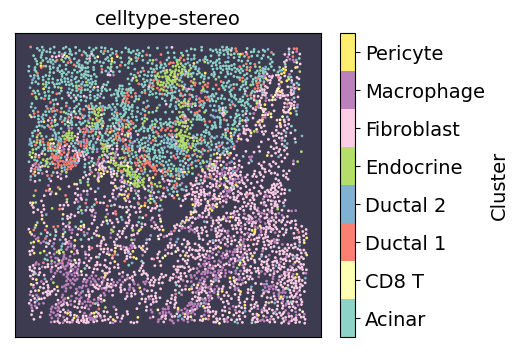

In [26]:
spatial = pd.DataFrame(ad.obsm['spatial'], columns=['X','Y'])
spatial['Cluster'] = ad.obs['predictions'].values
fig, ax = plt.subplots()
ax.set_facecolor('#3D3B4F')
_= spatial.plot.scatter(x='X', y='Y', c='Cluster', ax=ax, figsize=(4.9,4), colormap='Set3', s=1)
_= plt.title('celltype-stereo')
_= plt.xticks([])
_= plt.yticks([])
_= plt.xlabel('')
_= plt.ylabel('')
savepic(pic_pth, 'celltype-stereo')
plt.show()

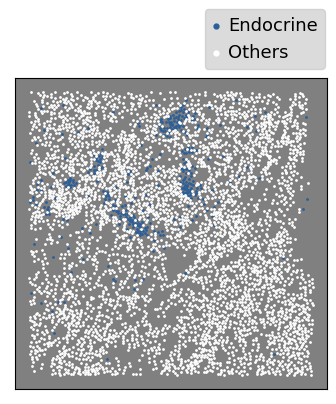

In [109]:
fig, ax = plt.subplots(figsize=(4,4.1))
_= ax.set_facecolor('gray')
t1 = spatial.loc[spatial['Cluster']=='Endocrine',:]
t2 = spatial.loc[spatial['Cluster']!='Endocrine',:]
type1 = ax.scatter(t1['X'].values, t1['Y'].values, s=1, c='#2b5f99')
type2 = ax.scatter(t2['X'].values, t2['Y'].values, s=1, c='#ffffff')
_= plt.title('')
_= plt.xticks([])
_= plt.yticks([])
_= plt.xlabel('')
_= plt.ylabel('')
_=ax.legend((type1, type2), ("Endocrine", "Others"), bbox_to_anchor=(0.58, 1.),facecolor='lightgray',markerscale=3.5)
pic_pth = os.path.join(sd_pth, 'plots', 'simCompare')
savepic(pic_pth,'stereo')

### sprod

In [138]:
meta = pd.DataFrame(spatial, index=range(spatial.shape[0]), columns=['X','Y'])

xnorm = load(wpth+'/xnorm')
cts = pd.DataFrame(xnorm, index=range(xnorm.shape[0]), columns=range(xnorm.shape[1]))
inpth = os.path.join(wpth,'input')
outpth = os.path.join(wpth,'output')
if not os.path.exists(inpth):
    os.makedirs(inpth)
else:
    shutil.rmtree(inpth)
    os.makedirs(inpth)
if not os.path.exists(outpth):
    os.makedirs(outpth)
else:
    shutil.rmtree(outpth)
    os.makedirs(outpth)

meta.to_csv(inpth+'/Spot_metadata.csv')
cts.to_csv(inpth+'/Counts.txt', sep='\t')

In [ ]:
# python sprod.py inpth outpth/res -k 10 -l 20 -r 0.1 -y batch -pb 4
# python sprod.py inpth outpth -k 10 -l 20 -r 0.1 -y single -ws -ag

In [7]:
sprod_pth = os.path.join(wpth, 'output', 'res')
xsprod = pd.read_csv(sprod_pth+'/denoised_stitched.txt', sep='\t', index_col=0)
xsprod = xsprod.to_numpy()
save(xsprod, wpth+'/xsprod')

### wedge

In [26]:
#csv
wdg_pth = '/home/qukun/muziyu/wdg'
xnorm = load(wpth+'/xnorm')
index = list(map(lambda x:'gene'+str(x),range(xnorm.shape[1])))
col = list(map(lambda x:'cell'+str(x),range(xnorm.shape[0])))
cts = pd.DataFrame(xnorm.T, index=index, columns=col)
cts.to_csv(wdg_pth+'/stereo.csv', sep=',',index=False)

In [33]:
#result
wdg_pth = '/home/qukun/muziyu/sprod_data/sim/wedge/stereo/'
W = pd.read_csv(wdg_pth+'W.csv', header=None)
W = W.to_numpy()
H = pd.read_csv(wdg_pth+'H.csv', header=None)
H = H.to_numpy()
rk_wdg = W.shape[1]
save(rk_wdg, wpth+'/rk_wdg')
xwedge = np.dot(W, H)
save(xwedge.T, wpth+'/xwedge')

### similarity matrix

In [140]:
xnorm = load(wpth+'/xnorm')
sim = calc.SNN(xnorm)
save(sim, wpth+'/sSNN')

In [8]:
sim_sr = pd.read_csv(wpth+'/output/sprod_Detected_graph.txt', sep='\t')
sim_sr = sim_sr.to_numpy()
save(sim_sr, wpth+'/sSPR')

### dimension check

In [141]:
xnorm = load(wpth+'/xnorm')
dim_w, dim_a = calc.rank_w_a(xnorm)
save(dim_w, wpth+'/dim_wedge')
save(dim_a, wpth+'/dim_alra')
print('      wedge','alra')
print('stereo',':', dim_w, dim_a)

      wedge alra
stereo : 3 3


In [9]:
calc.svdSIGdif_plot(wpth, dname='-stereo')

In [33]:
dw = load(wpth+'/dim_wedge')
for m in multiple:
    d=dw*m
    for w in weight:
        file = 'w'+flo2str(w)+'-l'+flo2str(lamb)+'-d'+flo2str(d)
        for init in initial:
            for sim in similarity:
                res_pth = os.path.join(wpth, 'result', init, file, sim)
                if not os.path.exists(res_pth+'/x_'+sim+'.pkl'):
                    print(m,w,init,sim)

### statistics

In [6]:
# time
time_dict = {}

wlist = weight
dim_w = load(wpth+'/dim_wedge')
dlist = list(map(lambda x:min(dim_w * x, 35), multiple))
        
for sim in similarity:
    time_dict_sim = {}
    for init in initial:
        runTime = []
        for w in wlist:
            for d in dlist:
                file = 'w'+flo2str(w)+'-l'+flo2str(lamb)+'-d'+flo2str(d)
                res_pth = os.path.join(wpth, 'result', init, file, sim)
                rt = load(res_pth+'/time_'+sim)
                runTime.append(rt)
        time_dict_sim[init] = np.mean(runTime) 
    time_dict[sim] = time_dict_sim
    
save(time_dict, wpth+'/time')

In [7]:
#cluster
J = 3000
ad = sc.read_h5ad(os.path.join(dpth, "stereoseq_J{}.h5ad".format(J)))#[:,:J]
obs = ad.obs
var = ad.var
del ad

In [8]:
dim_w = load(wpth+'/dim_wedge')
oriClus = obs['predictions'].values.tolist()
save(oriClus, wpth+'/oriClus')
for init in initial:
    for w in weight:
        file = 'w'+flo2str(w)+'-l'+flo2str(lamb)
        for m in multiple:
            dim = min(dim_w * m, 35)
            for sim in similarity:
                res_pth = os.path.join(wpth, 'result', init, file+'-d'+flo2str(dim), sim)
                uamp_pth = os.path.join(res_pth, 'umap')
                stat_pth = os.path.join(res_pth, 'statistics')
                if not os.path.exists(uamp_pth):
                    os.makedirs(uamp_pth)
                if not os.path.exists(stat_pth):
                    os.makedirs(stat_pth)
                    
                X = load(res_pth+'/x_'+sim)
                calc.umap(x=X, obs=obs, var=var, savepth=uamp_pth)
                umapClus = load(uamp_pth+'/umapClus')
                xpca = load(uamp_pth+'/xpca')
                
                ari = calc.ARI(oriClus, umapClus)
                save(ari, stat_pth+'/ari_'+sim)
                jcrd = calc.Jaccard(oriClus, umapClus)
                save(jcrd, stat_pth+'/jcrd_'+sim)
                slt = calc.Silhouette(xpca, umapClus)
                save(slt, stat_pth+'/slt_'+sim)

2023-05-21 14:07:33.002542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 14:07:38.514622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/gridview//pbs/dispatcher/lib:/opt/gridview//pbs/dispatcher/lib::/usr/local/lib64:/usr/local/lib:/usr/local/lib64:/usr/local/lib
2023-05-21 14:07:38.521029: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-21 14:08:02.683391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_lo

In [52]:
#wedge&sprod&norm
dim_w = load(wpth+'/dim_wedge')
oriClus = load(wpth+'/oriClus')
for method in ['norm','sprod','wedge']:
    umap_pth = os.path.join(wpth, 'statistics', method, 'umap')
    stat_pth = os.path.join(wpth, 'statistics', method)
    if not os.path.exists(umap_pth):
        os.makedirs(umap_pth)
    if not os.path.exists(stat_pth):
        os.makedirs(stat_pth)
        
    X = load(wpth+'/x'+method)
    calc.umap(x=X, obs=obs, var=var, savepth=umap_pth)
    umapClus = load(umap_pth+'/umapClus')
    xpca = load(umap_pth+'/xpca')
    
    ari = calc.ARI(oriClus, umapClus)
    save(ari, stat_pth+'/ari_'+method)
    jcrd = calc.Jaccard(oriClus, umapClus)
    save(jcrd, stat_pth+'/jcrd_'+method)
    slt = calc.Silhouette(xpca, umapClus)
    save(slt, stat_pth+'/slt_'+method)

In [10]:
#lambda
lambdas = [5,18,25,30]
w = 0.3
dim = 12
init = 'wdgsvd'
sim = 'SPR'
file = 'w'+flo2str(w)+'-d'+flo2str(dim)
oriClus = load(wpth+'/oriClus')
for lamb in lambdas:
    res_pth = os.path.join(wpth, 'result', file, 'l'+flo2str(lamb))
    umap_pth = os.path.join(res_pth, 'umap')
    stat_pth = os.path.join(res_pth, 'statistics')
    if not os.path.exists(umap_pth):
        os.makedirs(umap_pth)
    if not os.path.exists(stat_pth):
        os.makedirs(stat_pth)
        
    X = load(res_pth+'/x_'+sim)
    calc.umap(x=X, obs=obs, var=var, savepth=umap_pth)
    umapClus = load(umap_pth+'/umapClus')
    xpca = load(umap_pth+'/xpca')
    
    ari = calc.ARI(oriClus, umapClus)
    save(ari, stat_pth+'/ari_'+sim)
    jcrd = calc.Jaccard(oriClus, umapClus)
    save(jcrd, stat_pth+'/jcrd_'+sim)
    slt = calc.Silhouette(xpca, umapClus)
    save(slt, stat_pth+'/slt_'+sim)